## Generate the mesh

In [1]:
from mesh import three_cubes

size = 0.05
filename = f"meshes/mesh_{size}.msh"

three_cubes(filename, size=size)

Info    : Meshing 1D...nts                                                                                                             
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 20%] Meshing curve 4 (Line)
Info    : [ 20%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 6 (Line)
Info    : [ 30%] Meshing curve 7 (Line)
Info    : [ 30%] Meshing curve 8 (Line)
Info    : [ 30%] Meshing curve 9 (Line)
Info    : [ 40%] Meshing curve 10 (Line)
Info    : [ 40%] Meshing curve 11 (Line)
Info    : [ 40%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 50%] Meshing curve 14 (Line)
Info    : [ 60%] Meshing curve 15 (Line)
Info    : [ 60%] Meshing curve 16 (Line)
Info    : [ 60%] Meshing curve 17 (Line)
Info    : [ 70%] Meshing curve 18 (Line)
Info    : [ 70%] Meshing curve 19 (Line)
Info    : [ 70%] Meshing curve 20 (Line)
Info    : [ 80%] Meshing curve 21 (Line)
Info    : [ 

In [2]:
from convert_mesh import convert_mesh

volume_file = f"meshes/mesh_{size}.xdmf"
facet_file = f"meshes/mesh_{size}_facet.xdmf"

print(filename, volume_file, facet_file)
nb_cells, nb_facets = convert_mesh(filename, volume_file, facet_file)


meshes/mesh_0.05.msh meshes/mesh_0.05.xdmf meshes/mesh_0.05_facet.xdmf

Surface IDs:  [4 5 6 7]
Volume IDs:  [1 2 3]


In [3]:
# check if we are in github actions
import os
if "CI" in os.environ:
    num_procs = [1, 2, 4]
else:
    num_procs = [1, 2, 4, 8, 16]

In [4]:
import ipyparallel as ipp
import numpy as np

def run(volume_file: str, facet_file: str) -> float:
    from script_festim_2 import run_festim_2_nietsche
    import time

    start = time.perf_counter()
    run_festim_2_nietsche(volume_file, facet_file)
    end = time.perf_counter()

    elapsed_time = end - start


    return elapsed_time


runtimes_nietsche = np.zeros_like(num_procs, dtype=np.float64)

for i, num_proc in enumerate(num_procs):
    print(f"Running with {num_proc} processes")


    # start an ipyparallel cluster and connect to it
    cluster = ipp.Cluster(engines="mpi", n=num_proc)
    rc = cluster.start_and_connect_sync()

    # run the function run in parallel
    query = rc[:].apply_async(run, volume_file, facet_file)
    query.wait()

    # get the results for all processes
    elapsed_times = query.get()
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    print(elapsed_times)
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    runtime = np.max(elapsed_times)
    print(f"Elapsed times: {elapsed_times} seconds, max {runtime=:.2e}")

    runtimes_nietsche[i] = runtime

Running with 1 processes
Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 1/1 [00:05<00:00,  5.50s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 278783, 'identifier': 'ipcontroller-1731592488-wghr-278603'}
Stopping engine(s): 1731592489
Output for ipengine-1731592488-wghr-1731592489-278603:
2024-11-14 08:54:49.677 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:54:49.677 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:54:49.751 [IPEngine] Registering with controller at tcp://127.0.0.1:39003
2024-11-14 08:54:49.754 [IPEngine] Shell_addrs: ['tcp://127.0.0.1:38637', 'tcp://127.0.0.1:58737', 'tcp://127.0.0.1:33709']
2024-11-14 08:54:49.754 [IPEngine] Connecting shell to tcp://127.0.0.1:38637
2024-11-14 08:54:49.754 [IPEngine] Connecting shell to tcp://127.0.0.1:58737
2024-11-14 08:54:49.754 [IPEngine] Connecting shell to tcp://127.0.0.1:33709
2024-11-14 08:54:49.754 [IPEn

/tmp/ipykernel_278603/2426040031.py:35: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_278603/2426040031.py:39: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 2/2 [00:05<00:00,  2.75s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 279033, 'identifier': 'ipcontroller-1731592514-p0mz-278603'}
Stopping engine(s): 1731592515
Output for ipengine-1731592514-p0mz-1731592515-278603:
2024-11-14 08:55:15.732 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:55:15.732 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:55:15.732 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:55:15.732 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:55:15.807 [IPEngine.0] Registering with controller at tcp://127.0.0.1:37187
2024-11-14 08:55:15.807 [IPEngine.1] Registering with controller at tcp://127.0.0.1:37187
2024-11-14 08:55:15.808 [IPEngine.1] Requesting id: 1
2024-11-14 08:55:15.808 [IPEngine.0] Requesting id: 0
2024-11-14 08:55:15.809 [IPEngine.0] Shell_addrs: [

/tmp/ipykernel_278603/2426040031.py:35: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_278603/2426040031.py:39: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:05<00:00,  1.36s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 279244, 'identifier': 'ipcontroller-1731592535-bf0s-278603'}
Stopping engine(s): 1731592536
Output for ipengine-1731592535-bf0s-1731592536-278603:
2024-11-14 08:55:36.990 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:55:36.991 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:55:36.991 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:55:36.991 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:55:36.994 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:55:36.994 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:55:36.997 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:55:36.997 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:55:37.068

/tmp/ipykernel_278603/2426040031.py:35: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_278603/2426040031.py:39: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 8/8 [00:05<00:00,  1.45engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 279483, 'identifier': 'ipcontroller-1731592555-6ymo-278603'}
Stopping engine(s): 1731592556
Output for ipengine-1731592555-6ymo-1731592556-278603:
2024-11-14 08:55:56.556 [IPEngine.1] Starting nanny
2024-11-14 08:55:56.556 [IPEngine.3] Starting nanny
2024-11-14 08:55:56.557 [IPEngine.2] Shell_addrs: ['tcp://127.0.0.1:33025', 'tcp://127.0.0.1:51395', 'tcp://127.0.0.1:37285']
2024-11-14 08:55:56.557 [IPEngine.4] Shell_addrs: ['tcp://127.0.0.1:33025', 'tcp://127.0.0.1:51395', 'tcp://127.0.0.1:37285']
2024-11-14 08:55:56.557 [IPEngine.2] Connecting shell to tcp://127.0.0.1:33025
2024-11-14 08:55:56.557 [IPEngine.2] Connecting shell to tcp://127.0.0.1:51395
2024-11-14 08:55:56.557 [IPEngine.4] Connecting shell to tcp://127.0.0.1:33025
2024-11-14 08:55:56.557 [IPEngine.2] Connecting shell to tcp:/

/tmp/ipykernel_278603/2426040031.py:35: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_278603/2426040031.py:39: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 16 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 16/16 [00:05<00:00,  2.90engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 279782, 'identifier': 'ipcontroller-1731592574-yw8j-278603'}
Stopping engine(s): 1731592575
Output for ipengine-1731592574-yw8j-1731592575-278603:

2024-11-14 08:56:16.390 [IPEngine.13] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-14 08:56:16.392 [IPEngine.13] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-11-14 08:56:16.392 [IPEngine.13] Completed registration with id 13
2024-11-14 08:56:16.395 [IPEngine.14] Running code in user namespace: 
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-14 08:56:16.397 [IPEngine.14] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-14 08:56:16.399 [IPEngine.14] Starting to monitor the heartbeat signal from the hub eve

/tmp/ipykernel_278603/2426040031.py:35: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_278603/2426040031.py:39: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


In [5]:
def run_penalty(volume_file: str, facet_file: str) -> float:
    from script_festim_2 import run_festim_2_penalty
    import time

    start = time.perf_counter()
    run_festim_2_penalty(volume_file, facet_file)
    end = time.perf_counter()

    elapsed_time = end - start


    return elapsed_time


import ipyparallel as ipp
import numpy as np

runtimes_penalty = np.zeros_like(num_procs, dtype=np.float64)

for i, num_proc in enumerate(num_procs):
    print(f"Running with {num_proc} processes")


    # start an ipyparallel cluster and connect to it
    cluster = ipp.Cluster(engines="mpi", n=num_proc)
    rc = cluster.start_and_connect_sync()

    # run the function run in parallel
    query = rc[:].apply_async(run_penalty, volume_file, facet_file)
    query.wait()

    # get the results for all processes
    elapsed_times = query.get()
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    print(elapsed_times)
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    runtime = np.max(elapsed_times)
    print(f"Elapsed times: {elapsed_times} seconds, max {runtime=:.2e}")

    runtimes_penalty[i] = runtime


Running with 1 processes
Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 1/1 [00:05<00:00,  5.52s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 280243, 'identifier': 'ipcontroller-1731592597-cltp-278603'}
Stopping engine(s): 1731592598
Output for ipengine-1731592597-cltp-1731592598-278603:
2024-11-14 08:56:38.679 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:56:38.679 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:56:38.774 [IPEngine] Registering with controller at tcp://127.0.0.1:48409
2024-11-14 08:56:38.776 [IPEngine] Shell_addrs: ['tcp://127.0.0.1:36173', 'tcp://127.0.0.1:37945', 'tcp://127.0.0.1:55617']
2024-11-14 08:56:38.776 [IPEngine] Connecting shell to tcp://127.0.0.1:36173
2024-11-14 08:56:38.776 [IPEngine] Connecting shell to tcp://127.0.0.1:37945
2024-11-14 08:56:38.776 [IPEngine] Connecting shell to tcp://127.0.0.1:55617
2024-11-14 08:56:38.776 [IPEn

/tmp/ipykernel_278603/1588532262.py:35: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_278603/1588532262.py:39: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 2/2 [00:05<00:00,  2.75s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 280475, 'identifier': 'ipcontroller-1731592623-hqmk-278603'}
Stopping engine(s): 1731592624
Output for ipengine-1731592623-hqmk-1731592624-278603:
2024-11-14 08:57:04.795 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:57:04.795 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:57:04.796 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:57:04.796 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:57:04.865 [IPEngine.1] Registering with controller at tcp://127.0.0.1:35043
2024-11-14 08:57:04.865 [IPEngine.0] Registering with controller at tcp://127.0.0.1:35043
2024-11-14 08:57:04.866 [IPEngine.1] Requesting id: 1
2024-11-14 08:57:04.866 [IPEngine.0] Requesting id: 0
2024-11-14 08:57:04.867 [IPEngine.1] Shell_addrs: [

/tmp/ipykernel_278603/1588532262.py:35: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_278603/1588532262.py:39: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:05<00:00,  1.37s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 280688, 'identifier': 'ipcontroller-1731592644-n10c-278603'}
Stopping engine(s): 1731592645
Output for ipengine-1731592644-n10c-1731592645-278603:
2024-11-14 08:57:26.215 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:57:26.215 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:57:26.216 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:57:26.216 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:57:26.217 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:57:26.217 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:57:26.217 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:57:26.218 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:57:26.289

/tmp/ipykernel_278603/1588532262.py:35: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_278603/1588532262.py:39: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 8/8 [00:05<00:00,  1.45engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 280918, 'identifier': 'ipcontroller-1731592663-cq7w-278603'}
Stopping engine(s): 1731592664
Output for ipengine-1731592663-cq7w-1731592664-278603:
2024-11-14 08:57:45.310 [IPEngine.7] Connecting shell to tcp://127.0.0.1:47431
2024-11-14 08:57:45.310 [IPEngine.7] Starting nanny
2024-11-14 08:57:45.310 [IPEngine.5] Shell_addrs: ['tcp://127.0.0.1:57573', 'tcp://127.0.0.1:34691', 'tcp://127.0.0.1:47431']
2024-11-14 08:57:45.310 [IPEngine.1] Shell_addrs: ['tcp://127.0.0.1:57573', 'tcp://127.0.0.1:34691', 'tcp://127.0.0.1:47431']
2024-11-14 08:57:45.310 [IPEngine.5] Connecting shell to tcp://127.0.0.1:57573
2024-11-14 08:57:45.310 [IPEngine.5] Connecting shell to tcp://127.0.0.1:34691
2024-11-14 08:57:45.311 [IPEngine.1] Connecting shell to tcp://127.0.0.1:57573
2024-11-14 08:57:45.311 [IPEngine.5

/tmp/ipykernel_278603/1588532262.py:35: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_278603/1588532262.py:39: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 16 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 16/16 [00:05<00:00,  2.90engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 281215, 'identifier': 'ipcontroller-1731592682-aedn-278603'}
Stopping engine(s): 1731592683
Output for ipengine-1731592682-aedn-1731592683-278603:
2024-11-14 08:58:04.441 [IPEngine.6] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-11-14 08:58:04.442 [IPEngine.6] Completed registration with id 6
2024-11-14 08:58:04.442 [IPEngine.1] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-11-14 08:58:04.442 [IPEngine.1] Completed registration with id 1
2024-11-14 08:58:04.443 [IPEngine.7] Running code in user namespace: 
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-14 08:58:04.445 [IPEngine.7] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-14 08:58:04.447 [IPEn

/tmp/ipykernel_278603/1588532262.py:35: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_278603/1588532262.py:39: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


In [6]:
def run_change_of_var(volume_file: str, facet_file: str) -> float:
    from script_festim_2 import run_festim_2_change_of_var
    import time

    start = time.perf_counter()
    run_festim_2_change_of_var(volume_file, facet_file)
    end = time.perf_counter()

    elapsed_time = end - start


    return elapsed_time

runtimes_change_of_var = np.zeros_like(num_procs, dtype=np.float64)

for i, num_proc in enumerate(num_procs):
    print(f"Running with {num_proc} processes")


    # start an ipyparallel cluster and connect to it
    cluster = ipp.Cluster(engines="mpi", n=num_proc)
    rc = cluster.start_and_connect_sync()

    # run the function run in parallel
    query = rc[:].apply_async(run_change_of_var, volume_file, facet_file)
    query.wait()

    # get the results for all processes
    elapsed_times = query.get()
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    print(elapsed_times)
    rc.cluster.stop_cluster_sync()
    cluster.stop_cluster()

    runtime = np.max(elapsed_times)
    print(f"Elapsed times: {elapsed_times} seconds, max {runtime=:.2e}")

    runtimes_change_of_var[i] = runtime


Running with 1 processes
Starting 1 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 1/1 [00:05<00:00,  5.52s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 281679, 'identifier': 'ipcontroller-1731592706-6eue-278603'}
Stopping engine(s): 1731592707
Output for ipengine-1731592706-6eue-1731592707-278603:
2024-11-14 08:58:27.814 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:58:27.814 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:58:27.929 [IPEngine] Registering with controller at tcp://127.0.0.1:47241
2024-11-14 08:58:27.931 [IPEngine] Shell_addrs: ['tcp://127.0.0.1:34201', 'tcp://127.0.0.1:46423', 'tcp://127.0.0.1:47851']
2024-11-14 08:58:27.932 [IPEngine] Connecting shell to tcp://127.0.0.1:34201
2024-11-14 08:58:27.932 [IPEngine] Connecting shell to tcp://127.0.0.1:46423
2024-11-14 08:58:27.932 [IPEngine] Connecting shell to tcp://127.0.0.1:47851
2024-11-14 08:58:27.932 [IPEn

/tmp/ipykernel_278603/2447814170.py:31: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_278603/2447814170.py:35: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 2 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 2/2 [00:05<00:00,  2.74s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 281909, 'identifier': 'ipcontroller-1731592731-ce8a-278603'}
Stopping engine(s): 1731592732
Output for ipengine-1731592731-ce8a-1731592732-278603:
2024-11-14 08:58:53.209 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:58:53.209 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:58:53.212 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:58:53.212 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:58:53.279 [IPEngine.0] Registering with controller at tcp://127.0.0.1:58461
2024-11-14 08:58:53.279 [IPEngine.1] Registering with controller at tcp://127.0.0.1:58461
2024-11-14 08:58:53.279 [IPEngine.0] Requesting id: 0
2024-11-14 08:58:53.279 [IPEngine.1] Requesting id: 1
2024-11-14 08:58:53.281 [IPEngine.1] Shell_addrs: [

/tmp/ipykernel_278603/2447814170.py:31: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_278603/2447814170.py:35: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 4 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 4/4 [00:05<00:00,  1.38s/engine]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 282132, 'identifier': 'ipcontroller-1731592754-br9h-278603'}
Stopping engine(s): 1731592755
Output for ipengine-1731592754-br9h-1731592755-278603:
2024-11-14 08:59:15.821 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:59:15.821 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:59:15.822 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:59:15.822 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:59:15.823 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:59:15.823 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:59:15.823 [IPEngine] Loading connection info from $IPP_CONNECTION_INFO
2024-11-14 08:59:15.823 [IPEngine] WARNING | Not using CurveZMQ security
2024-11-14 08:59:15.891

/tmp/ipykernel_278603/2447814170.py:31: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_278603/2447814170.py:35: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 8 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 8/8 [00:05<00:00,  1.45engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 282365, 'identifier': 'ipcontroller-1731592774-tbfa-278603'}
Stopping engine(s): 1731592775
Output for ipengine-1731592774-tbfa-1731592775-278603:
2024-11-14 08:59:35.559 [IPEngine.3] Connecting shell to tcp://127.0.0.1:33745
2024-11-14 08:59:35.559 [IPEngine.3] Connecting shell to tcp://127.0.0.1:55443
2024-11-14 08:59:35.559 [IPEngine.3] Starting nanny
2024-11-14 08:59:35.559 [IPEngine.2] Connecting shell to tcp://127.0.0.1:43101
2024-11-14 08:59:35.560 [IPEngine.2] Connecting shell to tcp://127.0.0.1:33745
2024-11-14 08:59:35.560 [IPEngine.7] Shell_addrs: ['tcp://127.0.0.1:43101', 'tcp://127.0.0.1:33745', 'tcp://127.0.0.1:55443']
2024-11-14 08:59:35.560 [IPEngine.2] Connecting shell to tcp://127.0.0.1:44545
2024-11-14 08:59:35.560 [IPEngine.2] Starting nanny
2024-11-14 08:59:35.560 [IPEng

/tmp/ipykernel_278603/2447814170.py:31: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_278603/2447814170.py:35: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


Starting 16 engines with <class 'ipyparallel.cluster.launcher.MPIEngineSetLauncher'>
100%|██████████| 16/16 [00:05<00:00,  2.89engine/s]
Stopping controller
Controller stopped: {'exit_code': 0, 'pid': 282679, 'identifier': 'ipcontroller-1731592794-um61-278603'}
Stopping engine(s): 1731592795
Output for ipengine-1731592794-um61-1731592795-278603:

2024-11-14 08:59:56.669 [IPEngine.10] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-14 08:59:56.669 [IPEngine.0] Running code in user namespace: 
from mpi4py import MPI
mpi_rank = MPI.COMM_WORLD.Get_rank()
mpi_size = MPI.COMM_WORLD.Get_size()

2024-11-14 08:59:56.670 [IPEngine.10] Starting to monitor the heartbeat signal from the hub every 3500 ms.
2024-11-14 08:59:56.671 [IPEngine.10] Completed registration with id 10
2024-11-14 08:59:56.671 [IPEngine.0] WARNING | debugpy_stream undefined, debugging will not be enabled
2024-11-14 08:59:56.672 [IPEngine.0] Starting to monitor the heartbeat signal from the hub every 

/tmp/ipykernel_278603/2447814170.py:31: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()
/tmp/ipykernel_278603/2447814170.py:35: RuntimeWarning: coroutine 'Cluster.stop_cluster' was never awaited
  cluster.stop_cluster()


[lap-mathurin-01:278603] shmem: mmap: an error occurred while determining whether or not /tmp/ompi.lap-mathurin-01.1000/jf.0/669843456/shared_mem_cuda_pool.lap-mathurin-01 could be created.
[lap-mathurin-01:278603] create_and_attach: unable to create shared memory BTL coordinating structure :: size 134217728 


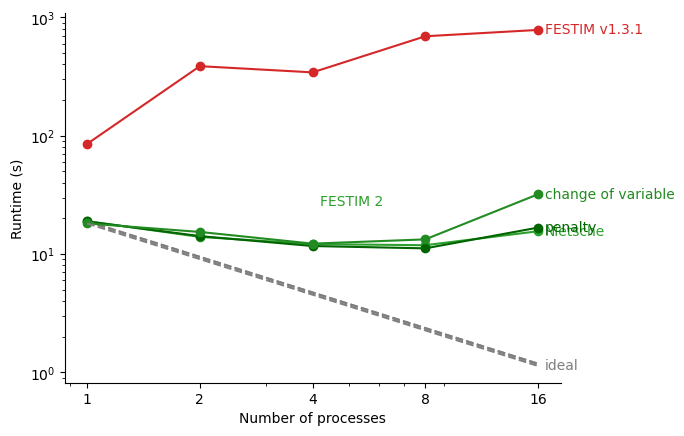

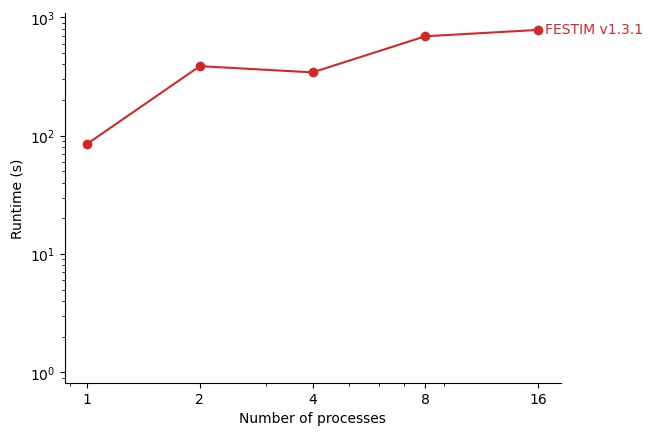

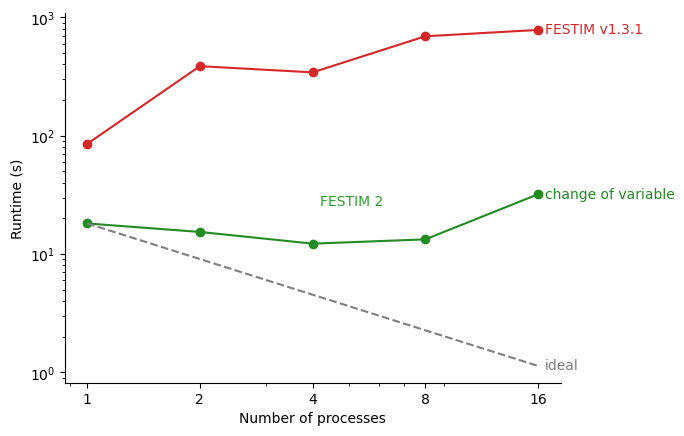

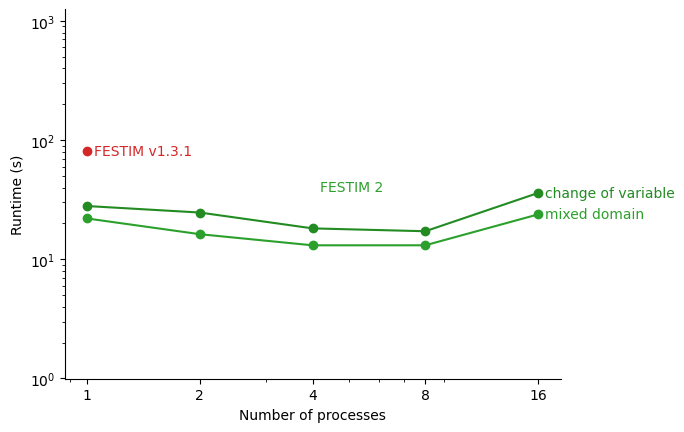

In [90]:
import matplotlib.pyplot as plt
from festim import __version__


def plot_runtime(
    runtimes_nietsche: np.ndarray = None,
    runtimes_change_of_var: np.ndarray = None,
    penalty: np.ndarray = None,
    show_festim_1: bool = True,
    show_ideal: bool = True,
    nb_festim_1_points: int = None,
):
    lines = []
    if runtimes_nietsche is not None:
        (l_mixed,) = plt.plot(
            num_procs, runtimes_nietsche, marker="o", label=f"Nietsche", color="tab:green"
        )
        lines.append(l_mixed)
        if show_ideal:
            n = np.linspace(1, 16, 100)
            (l_ideal,) = plt.plot(
                n, runtimes_nietsche[0] * n**-1, linestyle="--", color="tab:grey"
            )
            # lines.append(l_ideal)
    if penalty is not None:
        # another green
        (l_penalty,) = plt.plot(
            num_procs, runtimes_penalty, marker="o", label="penalty", color="darkgreen"
        )
        lines.append(l_penalty)
        if show_ideal:
            n = np.linspace(1, 16, 100)
            (l_ideal,) = plt.plot(
                n, runtimes_penalty[0] * n**-1, linestyle="--", color="tab:grey"
            )
            # lines.append(l_ideal)
    if runtimes_change_of_var is not None:
        (l_change_var,) = plt.plot(
            num_procs,
            runtimes_change_of_var,
            marker="o",
            label="change of variable",
            color="forestgreen",
        )
        lines.append(l_change_var)
        if show_ideal:
            n = np.linspace(1, 16, 100)
            (l_ideal,) = plt.plot(
                n,
                runtimes_change_of_var[0] * n**-1,
                label="ideal",
                linestyle="--",
                color="tab:grey",
            )
            lines.append(l_ideal)

    if show_festim_1:
        # check that runtimes_festim_1.csv exists and plot the results
        try:
            import pandas as pd

            data = pd.read_csv("runtimes_festim_1.csv")
            x = data["num_procs"]
            y = data["runtimes"]
            if nb_festim_1_points is not None:
                x=x[:nb_festim_1_points]
                y=y[:nb_festim_1_points]
            (l_festim1,) = plt.plot(
                x,
                y,
                marker="o",
                label="FESTIM v1.3.1",
                color="tab:red",
            )
            lines.append(l_festim1)
        except FileNotFoundError:
            print("File runtimes_festim_1.csv not found")

    for line in lines:
        plt.annotate(
            f"{line.get_label()}",
            (line.get_xdata()[-1], line.get_ydata()[-1]),
            textcoords="offset points",
            xytext=(5, 0),
            ha="left",
            va="center",
            color=line.get_color(),
        )

    if runtimes_nietsche  is not None or runtimes_change_of_var is not None or penalty is not None:
        plt.annotate(
            "FESTIM 2",
            (num_procs[2], runtimes_change_of_var[2]),
            textcoords="offset points",
            xytext=(5, 30),
            ha="left",
            va="center",
            color="tab:green",
        )

    # plt.legend()
    plt.xlabel("Number of processes")
    plt.ylabel("Runtime (s)")

    plt.xscale("log")
    plt.yscale("log")

    # xticks only at the powers of 2
    plt.xticks(num_procs, num_procs)

    # remove top and right spines
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

from pathlib import Path
folder = "figures"
Path(folder).mkdir(parents=True, exist_ok=True)


# show everything
plot_runtime(runtimes_change_of_var=runtimes_change_of_var, runtimes_nietsche=runtimes_nietsche, penalty=True, show_ideal=True)
ylim = plt.gca().get_ylim()
xlim = plt.gca().get_xlim()
plt.savefig(f"{folder}/everything.svg", transparent=True, bbox_inches="tight")
plt.show()


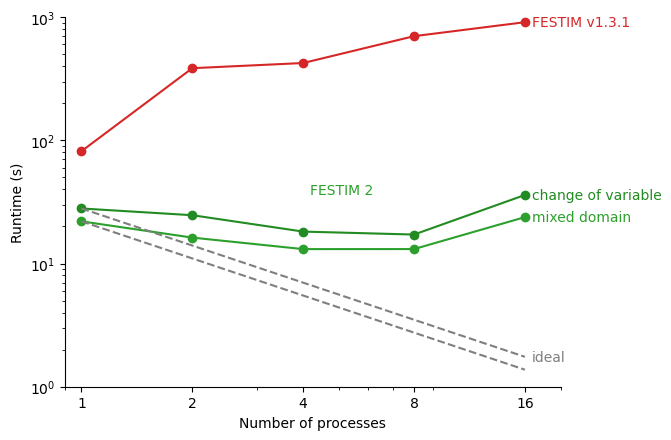

In [100]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation

# Define the update function for the animation
def update(frame):
    plt.clf()  # Clear the current figure
    
    if frame < total_nb_points:
        plot_runtime(nb_festim_1_points=frame + 1)
    elif frame == total_nb_points:
        plot_runtime(runtimes_change_of_var=runtimes_change_of_var, show_ideal=False)
    elif frame == total_nb_points + 1:
        plot_runtime(runtimes_change_of_var=runtimes_change_of_var, runtimes_mixed=runtimes, show_ideal=False)
    elif frame == total_nb_points + 2:
        plot_runtime(runtimes_change_of_var=runtimes_change_of_var, runtimes_mixed=runtimes, show_ideal=True)
    plt.gca().set_ylim(ylim)
    plt.gca().set_xlim(xlim)

    plt.savefig(f"{folder}/frame_{frame}.svg", transparent=True, bbox_inches="tight")  # Save each frame as an image file

total_nb_points = 5

# Initial plot to get the limits
ylim = (1, 1e3)
xlim = 0.9, 20

# Create the animation
fig = plt.figure()
ani = animation.FuncAnimation(fig, update, frames=total_nb_points+3, repeat=True)

# Save the animation as a video file
ani.save(f"{folder}/animation.mp4", writer='ffmpeg', fps=1)

# Display the animation
plt.show()

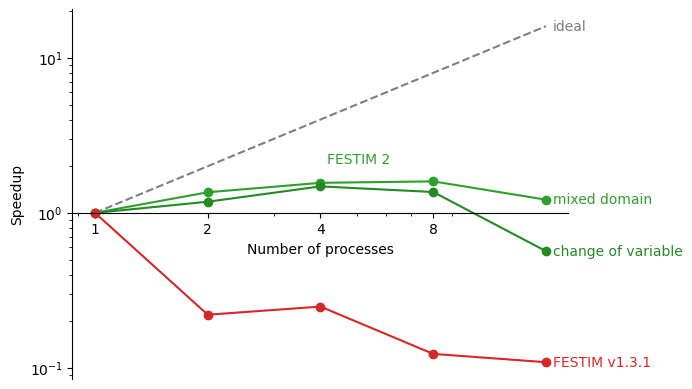

In [74]:
def plot_speedup(
    runtimes_nietsche: np.ndarray = None,
    runtimes_change_of_var: np.ndarray = None,
    show_festim_1: bool = True,
    show_ideal: bool = True,
):
    lines = []
    if runtimes_nietsche is not None:
        (l_mixed,) = plt.plot(
            num_procs, runtimes_nietsche[0] / runtimes_nietsche, marker="o", label=f"mixed domain", color="tab:green"
        )
        lines.append(l_mixed)

    if runtimes_change_of_var is not None:
        (l_change_var,) = plt.plot(
            num_procs,
            runtimes_change_of_var[0] / runtimes_change_of_var,
            marker="o",
            label="change of variable",
            color="forestgreen",
        )
        lines.append(l_change_var)

    if show_ideal:
        n = np.linspace(1, 16, 100)
        (l_ideal,) = plt.plot(
            n,
            n,
            label="ideal",
            linestyle="--",
            color="tab:grey",
        )
        lines.append(l_ideal)

    if show_festim_1:
        # check that runtimes_festim_1.csv exists and plot the results
        try:
            import pandas as pd

            data = pd.read_csv("runtimes_festim_1.csv")
            (l_festim1,) = plt.plot(
                data["num_procs"],
                data["runtimes"][0] / data["runtimes"],
                marker="o",
                label="FESTIM v1.3.1",
                color="tab:red",
            )
            lines.append(l_festim1)
        except FileNotFoundError:
            print("File runtimes_festim_1.csv not found")

    for line in lines:
        plt.annotate(
            f"{line.get_label()}",
            (num_procs[-1], line.get_ydata()[-1]),
            textcoords="offset points",
            xytext=(5, 0),
            ha="left",
            va="center",
            color=line.get_color(),
        )

    if runtimes_nietsche is not None or runtimes_change_of_var is not None:
        plt.annotate(
            "FESTIM 2",
            (num_procs[2], runtimes_nietsche[2]/runtimes_nietsche[0]),
            textcoords="offset points",
            xytext=(5, 60),
            ha="left",
            va="center",
            color="tab:green",
        )

    # move xaxis to y=1
    plt.gca().spines['bottom'].set_position(('data', 1))

    # plt.legend()
    plt.xlabel("Number of processes")
    plt.ylabel("Speedup")

    plt.xscale("log")
    plt.yscale("log")

    # xticks only at the powers of 2
    plt.xticks(num_procs[:-1], num_procs[:-1])

    # remove top and right spines
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

plot_speedup(runtimes_nietsche=runtimes_nietsche, runtimes_change_of_var=runtimes_change_of_var, show_ideal=True)